In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd

In [13]:
header = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)
ratings

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [14]:

u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

In [15]:
user2Idx

{196: 1,
 186: 2,
 22: 3,
 244: 4,
 166: 5,
 298: 6,
 115: 7,
 253: 8,
 305: 9,
 6: 10,
 62: 11,
 286: 12,
 200: 13,
 210: 14,
 224: 15,
 303: 16,
 122: 17,
 194: 18,
 291: 19,
 234: 20,
 119: 21,
 167: 22,
 299: 23,
 308: 24,
 95: 25,
 38: 26,
 102: 27,
 63: 28,
 160: 29,
 50: 30,
 301: 31,
 225: 32,
 290: 33,
 97: 34,
 157: 35,
 181: 36,
 278: 37,
 276: 38,
 7: 39,
 10: 40,
 284: 41,
 201: 42,
 287: 43,
 246: 44,
 242: 45,
 249: 46,
 99: 47,
 178: 48,
 251: 49,
 81: 50,
 260: 51,
 25: 52,
 59: 53,
 72: 54,
 87: 55,
 42: 56,
 292: 57,
 20: 58,
 13: 59,
 138: 60,
 60: 61,
 57: 62,
 223: 63,
 189: 64,
 243: 65,
 92: 66,
 241: 67,
 254: 68,
 293: 69,
 127: 70,
 222: 71,
 267: 72,
 11: 73,
 8: 74,
 162: 75,
 279: 76,
 145: 77,
 28: 78,
 135: 79,
 32: 80,
 90: 81,
 216: 82,
 250: 83,
 271: 84,
 265: 85,
 198: 86,
 168: 87,
 110: 88,
 58: 89,
 237: 90,
 94: 91,
 128: 92,
 44: 93,
 264: 94,
 41: 95,
 82: 96,
 262: 97,
 174: 98,
 43: 99,
 84: 100,
 269: 101,
 259: 102,
 85: 103,
 213: 104,
 1

In [16]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [20]:
ratings

,userId,movieId,rating,timestamp
0,1,1,3,881250949
1,2,2,3,891717742
2,3,3,1,878887116
3,4,4,2,880606923
4,5,5,1,886397596
5,6,6,4,884182806
6,7,7,2,881171488
7,8,8,5,891628467
8,9,9,3,886324817
9,10,10,3,883603013


In [21]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [22]:
n_split = 20000
ratings_train = ratings[n_split:]
ratings_val = ratings[:n_split]
len(ratings_train), len(ratings_val)

(80000, 20000)

In [23]:
ratings_train

,userId,movieId,rating,timestamp
20000,392,13,2,877399864
20001,457,882,4,886365297
20002,111,61,4,875306477
20003,176,1315,2,874951695
20004,122,658,4,877879172
20005,19,61,5,874805453
20006,61,582,4,883325994
20007,436,503,4,879868005
20008,145,192,3,875240171
20009,460,358,3,885356089


In [24]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1682 943 1650


In [27]:
# Por el embedding que arranca en 1
ratings_train['userId'].max(), ratings_train['movieId'].max()

(943, 1682)

In [28]:
from keras.layers import Embedding, Input, Flatten, Dot
from keras import Model
from keras.constraints import non_neg

Using TensorFlow backend.


In [38]:
n_latent_factors = 20

In [39]:
movie_input = Input(shape=[1], name='Item')
# movie_embedding = Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_embedding = Embedding(n_movies + 1, n_latent_factors, embeddings_regularizer=l2(0.001),
                            name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
#user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 
#                                                  n_latent_factors,name='User-Embedding', embeddings_constraint=non_neg())(user_input))

In [40]:
prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 20)        33660       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        18880       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [41]:
from keras.optimizers import Adam

In [42]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [43]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [44]:
model.compile(Adam(lr=0.001), 'mean_squared_error', metrics=[root_mean_squared_error])

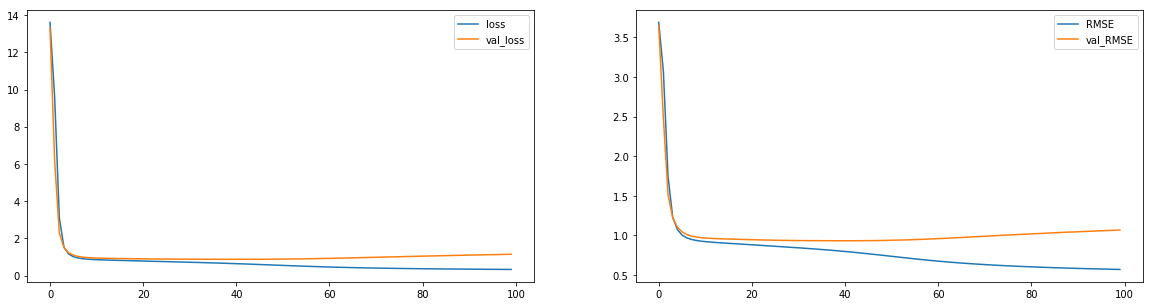

In [45]:
history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    batch_size=320,
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    epochs=100, 
                    callbacks = [plot_losses],
                    verbose=1)

In [46]:
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

20000/20000 [==============================] - 0s 13us/step


[1.142512119102478, 1.0573143545150756]

In [47]:
model.evaluate([ratings_train.userId, ratings_train.movieId], ratings_train.rating)

80000/80000 [==============================] - 1s 12us/step


[0.3113709267795086, 0.5520327876091004]